# Appendix

Hao Lu 04/04/2020

In this notebook, we simulated EEG data with the method described in the paper by Bharadwaj and Shinn-Cunningham and analyzed the data with the toolbox proposed in the same paper.

The function was modifed so the values of varibles within the function can be extracted and studied.

Reference:  
Bharadwaj, H. M., & Shinn-Cunningham, B. G. (2014). Rapid acquisition of auditory subcortical steady state responses using multichannel recordings. Clinical Neurophysiology, 125(9), 1878-1888.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

from scipy import linalg
from anlffr import spectral,dpss

/home/luxx0489/.conda/envs/mne/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
sfreq = 10000

random.seed(2020)
phase_list = [random.uniform(-np.pi,np.pi) for i in range(32)]

The phase of signal in 32 channels were randomly sampled from uniform distribution

Text(0, 0.5, 'Phase of signal')

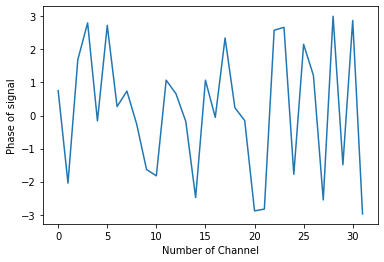

In [3]:
plt.plot(phase_list)
plt.xlabel('Number of Channel')
plt.ylabel('Phase of signal')

The signal is deifiend as 100 Hz SSSR

<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


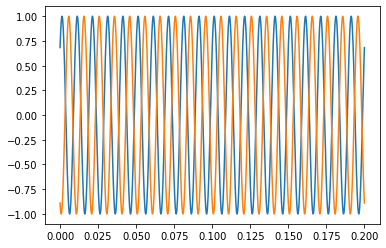

In [4]:
signal = np.zeros((32,200,int(sfreq*0.2)))
xt = np.linspace(0,0.2,sfreq*0.2)

for iChannel in range(32):
    for iTrial in range(200):
        signal[iChannel,iTrial,:] = np.sin(xt*100*2*np.pi+phase_list[iChannel])
        
# plot first two channels to show the phase differences
plt.plot(xt,signal[0:2,0,:].transpose())

The SNR in the simulated data was set as -40 dB for all channels

In [5]:
std = 10**(40/20)*np.sqrt((signal**2).mean())

noise = np.random.normal(0,std,signal.shape)

The simulated data was analyzed through the code from function anlffr.spectral.mtcplv

In [6]:
params = dict(Fs = sfreq, tapers = [1,1], fpass = [80, 120], itc = 0, pad = 1)

x=signal + noise


#codes from the dpss tool of anlffr to make sure the multitaper part is consistent

if(len(x.shape) == 3):
    timedim = 2
    trialdim = 1
    ntrials = x.shape[trialdim]
    nchans = x.shape[0]
    
nfft, f, fInd = spectral._get_freq_vector(x, params, timedim)
ntaps = params['tapers'][1]
TW = params['tapers'][0]
w, conc = dpss.dpss_windows(x.shape[timedim], TW, ntaps)


In [7]:
# the original version of mtcplv

plv = np.zeros((ntaps, len(fInd)))
for k, tap in enumerate(w):
    xw = np.fft.rfft(tap * x, n=nfft, axis=timedim)

    if params['itc']:
        C = (xw.mean(axis=trialdim) /
             (abs(xw).mean(axis=trialdim))).squeeze()
    else:
        C = (xw / abs(xw)).mean(axis=trialdim).squeeze()

    for fi in np.arange(0, C.shape[1]):
        Csd = np.outer(C[:, fi], C[:, fi].conj())
        vals = linalg.eigh(Csd, eigvals_only=True)
        plv[k, fi] = vals[-1] / nchans

# Average over tapers and squeeze to pretty shapes
plv = (plv.mean(axis=0)).squeeze()
plv = plv[fInd]

The mtcplv did capture the 100 Hz component 

Text(0, 0.5, 'output of mtcPLV')

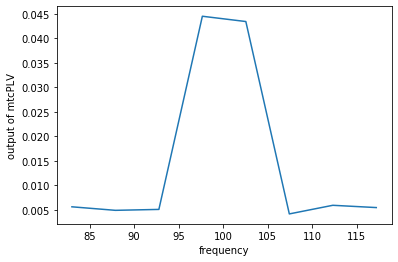

In [8]:
plt.plot(f,plv)
plt.xlabel('frequency')
plt.ylabel('output of mtcPLV')

However, the output of mtcplv is perfectly overlapped with the average of squared single-channel PLV stored in matrix C

Text(0, 0.5, 'PLV')

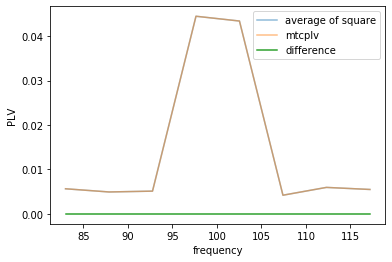

In [9]:
plt.plot(f,abs(C**2).mean(0)[fInd], label='average of square', alpha=0.5)
plt.plot(f,plv,label = 'mtcplv', alpha = 0.5)
plt.plot(f,abs(C**2).mean(0)[fInd] - plv, label='difference')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('PLV')

We then check the eigen value decomposition around the 100 Hz peak and there is only one non-zero eigen value as expected

Text(0, 0.5, 'Eigen Values')

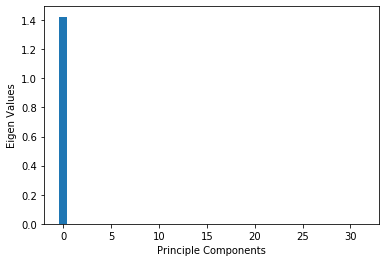

In [10]:
fi = np.argmax(plv)+np.argwhere(fInd==True).min()

Csd = np.outer(C[:, fi], C[:, fi].conj())
vals = linalg.eigh(Csd, eigvals_only=True)

plt.bar(np.arange(32),vals[::-1])
plt.xlabel('Principle Components')
plt.ylabel('Eigen Values')